In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!pip install tf2cv tensorflow>=2.0.0

In [3]:
from tensorflow.python.client import device_lib
dev=device_lib.list_local_devices()
dev[len(dev)-1]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18333869144928259530
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"

In [0]:
#global consts
IMG_SIZE='137x236'
HEIGHT = 137
WIDTH = 236
BATCH_SIZE=128
DROP_OUT=0.0
FOLD=0
TRAIN_DIR = './train/'
TRAIN_IMG_DIR=TRAIN_DIR+str(IMG_SIZE)
EPOCHS = 200
STATS_FS = (0.055029564364430086, 0.17228061284674265)
STATS_128 = (0.0692, 0.2051)
EXPERIMENT='sernext_3cmc_fullsize_wo_od_cw'
INPUT_DIR ='/content/drive/My Drive/kaggle/bengali/input/'
OUTPUT_DIR = '/content/drive/My Drive/kaggle/bengali/output/'
IMPORT_DIR = '/content/drive/My Drive/kaggle/bengali/nbs/'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'
CHKP_DIR = EXPERIMENT_DIR+'chkp/'
OUTPUT_SUBDIR = ''
DATASET_224='224x224-bengali.zip'
DATASET_128='grapheme-imgs-128x128.zip'
DATASET_FS = 'bengali-full-size.zip'
TRAIN_WITH_FOLD = 'train_with_fold_20.csv'
PRETRAINED = False
PRETRAINED_WEIGHTS = ''
LOG_FILE = EXPERIMENT_DIR+'log_'+EXPERIMENT+'.csv'
#INITIAL_EPOCH=40
#HEAD_WD=1e-3
#BACKBONE_WD = 1e-4

if IMG_SIZE == 128: DATASET=DATASET_128
if IMG_SIZE == 224: DATASET=DATASET_224
if IMG_SIZE == '137x236' : DATASET=DATASET_FS


#lr sheduler consts
LR_MAX = 0.001
LR_MIN = 0.00001
T_MAX = 100

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append(IMPORT_DIR+'py/models/')
sys.path.append(IMPORT_DIR+'py/utils/')
sys.path.append(IMPORT_DIR+'py/callbacks/')
sys.path.append(IMPORT_DIR+'py/opts/')

In [0]:
#import local modules
#from mish import Mish,mish
from generators import *
from kaggle_metric import *
from cosine import CosineAnnealingScheduler
from kagglevalidation import KaggleValidationFS
#from lookahead import Lookahead
from se_resnext50 import build_se_resnext50_model_fs_wod
#from md121v2 import build_md121_v2_model
#from losses import categorical_focal_loss


#import external modules
import numpy as np 
import pandas as pd 

import os
import errno

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight

In [18]:
try:
  os.mkdir(TRAIN_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_DIR+' already exists')
    else:
        raise
try:
  os.mkdir(TRAIN_IMG_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_IMG_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(EXPERIMENT_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(EXPERIMENT_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(CHKP_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(CHKP_DIR+' already exists')
    else:
        raise


os.system('cp '+ '"'+INPUT_DIR+DATASET+'" ' + TRAIN_DIR)
os.system('cp '+ '"'+INPUT_DIR+TRAIN_WITH_FOLD+'" ' + TRAIN_DIR)

./train/ already exists
/content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_wo_od_cw/ already exists
/content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_wo_od_cw/chkp/ already exists


0

In [0]:
if PRETRAINED: os.system('cp '+ '"'+OUTPUT_DIR+OUTPUT_SUBDIR+PRETRAINED_WEIGHTS+'" '+TRAIN_DIR)

In [19]:
os.system('unzip -q '+TRAIN_DIR+DATASET+ ' -d '+ TRAIN_IMG_DIR)

0

In [17]:
!ls train

bengali-full-size.zip  train_with_fold_20.csv


In [0]:
dataset_np = pd.read_csv(TRAIN_DIR+TRAIN_WITH_FOLD).to_numpy()
dataset_np[:,0]+='.png'
dataset_m = dataset_np.shape[0]


valid_m = np.where(dataset_np[:,6]==FOLD)[0].shape[0]
train_m = dataset_m-valid_m

fold_train_inds = np.where(dataset_np[:,6] != FOLD)
fold_valid_inds = np.where(dataset_np[:,6] == FOLD)

train_np = dataset_np[fold_train_inds]
valid_np = dataset_np[fold_valid_inds]

train_df = pd.DataFrame(train_np)
valid_df = pd.DataFrame(valid_np)

train_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)
valid_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)

train_df.drop(columns=[5,6], inplace=True)
valid_df.drop(columns=[5,6], inplace=True)

In [0]:
cons_unique=np.unique(train_np[:,3])
cons_y_train = train_np[:,3]
vowel_unique=np.unique(train_np[:,2])
vowel_y_train = train_np[:,2]
root_unique =np.unique(train_np[:,1])
root_y_train = train_np[:,1]

cons_class_weights = class_weight.compute_class_weight('balanced',
                                                 cons_unique,
                                                 cons_y_train)

vowel_class_weights = class_weight.compute_class_weight('balanced',
                                                 vowel_unique,
                                                 vowel_y_train)

root_class_weights = class_weight.compute_class_weight('balanced',
                                                 root_unique,
                                                 root_y_train)
cons_cw_dict=dict(enumerate(cons_class_weights))
vowel_cw_dict=dict(enumerate(vowel_class_weights))
root_cw_dict=dict(enumerate(root_class_weights))

model_cw={}
model_cw['root']=root_cw_dict
model_cw['vowel']=vowel_cw_dict
model_cw['consonant']=cons_cw_dict

In [0]:
model =  build_se_resnext50_model_fs_wod(height=HEIGHT, width=WIDTH)

In [0]:
if 0: model.summary()

In [0]:
if 0:
  from tensorflow.keras.utils import plot_model
  plot_model(model, to_file=OUTPUT_DIR+'model3.png',show_shapes=True)

In [0]:
if 0:
  for (n, layer) in enumerate(model.layers[1].layers):
    if 'activation' in layer.get_config() and layer.get_config()['activation'] == 'relu':
      print('replacing #{}: {}, {}'.format(n, layer, layer.activation))
      layer.activation = Mish(mish)
      print('-> {}'.format(layer.activation))

In [0]:
TRAIN_DIR+PRETRAINED_WEIGHTS

'./train/'

In [0]:
cutout_datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(p=0.95,s_l=0.05,s_h=0.3,r_1=0.8,r_2=1.2,v_l=0,v_h=0))

mcm_datagen = ImageDataGenerator()

In [20]:
columns=["root_class","vowel_class", "cons_class"]

mcm_generator1 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

mcm_generator2 = mcm_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")


cutout_generator = cutout_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_IMG_DIR,
        x_col="filename",
        y_col=columns,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode="multi_output",
        color_mode="grayscale")

Found 190798 validated image filenames.
Found 190798 validated image filenames.
Found 190798 validated image filenames.


In [0]:
def mine_hard_datagen(datagen,model,batch_size=BATCH_SIZE, st=STATS_FS):
  while True:
       samples, targets_root, targets_vowel, targets_cons = [], [], [], []
       print('mining start')
       while len(samples) < batch_size:
           x_data, y_data = prep_batch_fs_shuffled(next(datagen),st=st)
           preds = model.predict(x_data)
           errors = np.abs(preds[0] - y_data[0]).max(axis=-1) > .5
           samples += x_data[errors].tolist()
           targets_root  += y_data[0][errors].tolist()
           targets_vowel += y_data[1][errors].tolist()
           targets_cons  += y_data[2][errors].tolist()

       print('mining stoped')

       regular_samples = batch_size * 2 - len(samples)
       x_data, y_data = prep_batch_fs_shuffled(next(datagen),st=st)
       samples += x_data[:regular_samples].tolist()
       targets_root +=  y_data[0][:regular_samples].tolist()
       targets_vowel += y_data[1][:regular_samples].tolist()
       targets_cons +=  y_data[2][:regular_samples].tolist()

       samples, targets_root,targets_vowel, targets_cons = map(np.array, (samples, targets_root,targets_vowel, targets_cons))


       idx = np.arange(batch_size * 2)
       np.random.shuffle(idx)
       batch1, batch2 = np.split(idx, 2)
       yield samples[batch1], [targets_root[batch1], targets_vowel[batch1], targets_cons[batch1]]
       yield samples[batch2], [targets_root[batch2], targets_vowel[batch2], targets_cons[batch2]]

In [0]:
def g3_generator_fs2_minehard(model,gen1,gen2, gen3,h=137,w=236,st=STATS_FS):
    while True:
        p = np.random.rand()
        if p>0.5:
            x_res,y_res = next(gen3)
        else:
            batch1 = next(gen1)
            batch2 = next(gen2)
            q = np.random.rand()
            if q>0.3:
                x_res,y_res = mix_batches_fs(batch1,batch2,alpha=0.2,st=st)
            else:
                x_res,y_res = cutmix_batches_fs2(batch1,batch2,alpha=0.8,h=h,w=w,st=st)
        yield x_res,y_res

In [0]:
def g3_generator_fs2(gen1,gen2, gen3,h=137,w=236,st=STATS_FS):
    while True:
        p = np.random.rand()
        if p>0.8:
            batch = next(gen3)
            x_res,y_res = prep_batch_fs(batch,st=st)
        else:
            batch1 = next(gen1)
            batch2 = next(gen2)
            q = np.random.rand()
            if q>0.3:
                x_res,y_res = mix_batches_fs(batch1,batch2,alpha=0.2,st=st)
            else:
                x_res,y_res = cutmix_batches_fs2(batch1,batch2,alpha=0.8,h=h,w=w,st=st)
        yield x_res,y_res

In [0]:
if 0:
  mixup_datagen=mixup_data_gen(aux_data_gen(mcm_generator1),aux_data_gen(mcm_generator2))
  cutout_datagen=aux_data_gen(cutout_generator)
  h_datagen=hybrid_data_gen(mixup_datagen,cutout_datagen)
  h2_datagen=h_generator(mcm_generator1,mcm_generator2,cutout_generator)
  hmcm_datagen=hmcm_generator(mcm_generator1,mcm_generator2)
  g3_datagen = g3_generator(mcm_generator1,mcm_generator2,cutout_generator)
  g3_datagen_fs = g3_generator_fs(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_FS)
  cpsm_datagen_fs = cpsm_generator_fs(mcm_generator1,mcm_generator2,cutout_generator, st=STATS_FS)
  g3_datagen_fs = g3_generator_fs(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_FS)
  g3_datagen_fs2 = g3_generator_fs2(mcm_generator1,mcm_generator2,cutout_generator,h=HEIGHT,w=WIDTH, st=STATS_FS)

cutout_hard_generator = mine_hard_datagen(cutout_generator,model,batch_size=BATCH_SIZE, st=STATS_FS)
g3_datagen_fs2_mh=g3_generator_fs2_minehard(model,mcm_generator1,mcm_generator2,cutout_hard_generator,h=HEIGHT,w=WIDTH, st=STATS_FS)

mining start
mining stoped


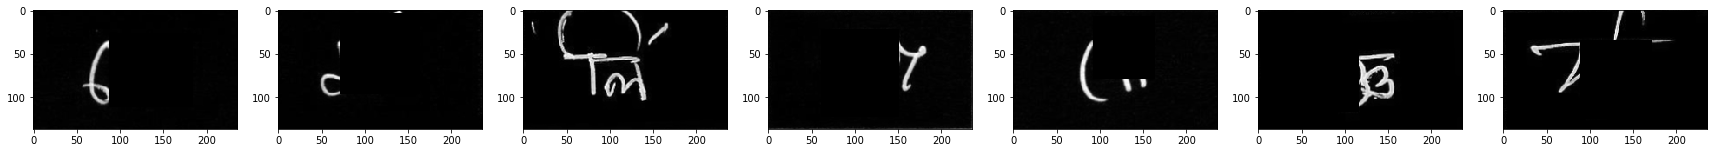

In [221]:
if 1: 
  batch_x,y = next(g3_datagen_fs2_mh)
  import matplotlib.pyplot as plt
  fig, axs = plt.subplots(1, 7, figsize=(30, 30))
  for i in range(7):
    axs[i].imshow(batch_x[i,:,:,0], cmap='gray')
  plt.show()

In [0]:
if 0: opt = Lookahead(tf.keras.optimizers.SGD(learning_rate=LR_MAX, momentum=0.9,nesterov=True))

opt=tf.keras.optimizers.Adam(learning_rate=LR_MAX)

In [0]:
checkpoint =  tf.train.Checkpoint(latest_epoch=tf.Variable(0), optimizer=opt, model=model)
chkp_manager =  tf.train.CheckpointManager(checkpoint, CHKP_DIR, max_to_keep=3)

In [197]:
chkp_manager.latest_checkpoint

'/content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_wo_od_cw/chkp/ckpt-451'

In [198]:
chkp_restore_status=checkpoint.restore(chkp_manager.latest_checkpoint)
if chkp_manager.latest_checkpoint:
  #chkp_restore_status.assert_consumed()
  print("Restored from {}".format(chkp_manager.latest_checkpoint))
  print(f"Lastest epoch {checkpoint.latest_epoch.numpy()}")
else:
  print("Initializing from scratch.")

Restored from /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_wo_od_cw/chkp/ckpt-451
Lastest epoch 451


In [0]:
loss_dict={'root':    'categorical_crossentropy',
           'vowel':    'categorical_crossentropy',
           'consonant':'categorical_crossentropy'}
model.compile(optimizer=opt, loss=loss_dict, loss_weights=[2.0,1.0,1.0])

In [224]:
initial_epoch = checkpoint.latest_epoch.numpy()

print(f'epochs trained: {initial_epoch}. start training epoch {initial_epoch+1}...')
#ca_shed = CosineAnnealingScheduler(T_max=100, eta_max=0.0001, eta_min=0.000001,verbose=1, initial_epoch=59)
#rolrplt = tf.keras.callbacks.ReduceLROnPlateau(monitor='kaggle',mode='max', patience=5, verbose=1, factor=0.5, min_lr=LR_MIN)


suffix =EXPERIMENT+\
                '_eps'+str(EPOCHS)+\
                '_iniep'+str(initial_epoch)+\
                '_sz'+str(IMG_SIZE)+\
                '_bs'+str(BATCH_SIZE)+\
                '_do'+str(DROP_OUT)+\
                '_'+model.optimizer.get_config()['name']+\
                '_IS_fold'+str(FOLD)


kv = KaggleValidationFS(valid_df,
                      batch_size=512,
                      vals_per_epoch=4,
                      train_steps=train_m//BATCH_SIZE+1,
                      logfile=EXPERIMENT_DIR+'log_kr_'+suffix+'.csv',
                      initial_epoch=initial_epoch,
                      suffix = suffix,
                      train_img_dir=TRAIN_IMG_DIR,
                      output_dir=EXPERIMENT_DIR,
                      thresholds=[0.987,0.995,0.994],
                      chkp_manager=chkp_manager,
                      in_shape=[HEIGHT,WIDTH],
                      st=STATS_FS)

tf.keras.backend.set_value(model.optimizer.lr, 0.0001)
cbs = [kv]

history=model.fit(g3_datagen_fs2_mh,
                  epochs=EPOCHS,
                  steps_per_epoch=train_m//BATCH_SIZE+1,
                  callbacks=cbs,
                  #class_weight=model_cw,
                  verbose=1)

epochs trained: 451. start training epoch 452...
Train for 1491 steps
Epoch 1/200
   6/1491 [..............................] - ETA: 23:25 - loss: 2.4761 - root_loss: 0.3765 - vowel_loss: 0.2778 - consonant_loss: 0.1693mining stoped
mining start
   8/1491 [..............................] - ETA: 56:51 - loss: 2.5369 - root_loss: 0.9929 - vowel_loss: 0.2622 - consonant_loss: 0.2140  mining stoped
mining start
  14/1491 [..............................] - ETA: 1:24:34 - loss: 2.9238 - root_loss: 1.3171 - vowel_loss: 0.6534 - consonant_loss: 0.3923mining stoped
mining start
  17/1491 [..............................] - ETA: 1:29:24 - loss: 2.7918 - root_loss: 0.7190 - vowel_loss: 0.2729 - consonant_loss: 0.2124mining stoped
mining start
  27/1491 [..............................] - ETA: 1:26:23 - loss: 2.9066 - root_loss: 0.8756 - vowel_loss: 0.5071 - consonant_loss: 0.3638mining stoped
mining start
  34/1491 [..............................] - ETA: 1:31:16 - loss: 2.8399 - root_loss: 0.3893 - 

mining stoped

[0:24:35] - kaggle:0.9883 - root:0.9834 -vowel:0.9938 - cons: 0.9926
 375/1491 [======>.......................] - ETA: 1:13:21 - loss: 2.4354 - root_loss: 0.9857 - vowel_loss: 0.3357 - consonant_loss: 0.1758mining stoped
mining start
 377/1491 [======>.......................] - ETA: 1:13:30 - loss: 2.4358 - root_loss: 1.1155 - vowel_loss: 0.3375 - consonant_loss: 0.2187mining stoped
mining start
 389/1491 [======>.......................] - ETA: 1:12:07 - loss: 2.4280 - root_loss: 0.9474 - vowel_loss: 0.5371 - consonant_loss: 0.3540mining stoped
mining start
 391/1491 [======>.......................] - ETA: 1:12:15 - loss: 2.4282 - root_loss: 0.9862 - vowel_loss: 0.3375 - consonant_loss: 0.2276mining stoped
mining start
 394/1491 [======>.......................] - ETA: 1:12:09 - loss: 2.4260 - root_loss: 0.7438 - vowel_loss: 0.2616 - consonant_loss: 0.1922mining stoped
mining start
 408/1491 [=======>......................] - ETA: 1:10:54 - loss: 2.4231 - root_loss: 0.907

mining stoped

[0:49:50] - kaggle:0.9891 - root:0.9847 -vowel:0.9942 - cons: 0.9926
 755/1491 [==============>...............] - ETA: 48:57 - loss: 2.4645 - root_loss: 1.2289 - vowel_loss: 0.5498 - consonant_loss: 0.3779mining stoped
mining start
 758/1491 [==============>...............] - ETA: 48:46 - loss: 2.4662 - root_loss: 1.1665 - vowel_loss: 0.5886 - consonant_loss: 0.3769mining stoped
mining start
 770/1491 [==============>...............] - ETA: 47:56 - loss: 2.4688 - root_loss: 1.5406 - vowel_loss: 0.7930 - consonant_loss: 0.5457mining stoped
mining start
 773/1491 [==============>...............] - ETA: 47:46 - loss: 2.4670 - root_loss: 0.6638 - vowel_loss: 0.2658 - consonant_loss: 0.1337mining stoped
mining start
 775/1491 [==============>...............] - ETA: 47:42 - loss: 2.4674 - root_loss: 0.8443 - vowel_loss: 0.3222 - consonant_loss: 0.1772mining stoped
mining start
 789/1491 [==============>...............] - ETA: 46:38 - loss: 2.4679 - root_loss: 1.3227 - vowel_lo

mining stoped

[1:13:35] - kaggle:0.9892 - root:0.9852 -vowel:0.9943 - cons: 0.9923
1130/1491 [=====================>........] - ETA: 23:41 - loss: 2.4421 - root_loss: 0.3625 - vowel_loss: 0.2602 - consonant_loss: 0.1511mining stoped
mining start
1133/1491 [=====================>........] - ETA: 23:30 - loss: 2.4408 - root_loss: 0.6180 - vowel_loss: 0.2131 - consonant_loss: 0.2047mining stoped
mining start
1136/1491 [=====================>........] - ETA: 23:19 - loss: 2.4400 - root_loss: 0.7157 - vowel_loss: 0.2860 - consonant_loss: 0.2054mining stoped
mining start
1144/1491 [======================>.......] - ETA: 22:47 - loss: 2.4421 - root_loss: 1.4380 - vowel_loss: 0.5054 - consonant_loss: 0.3977mining stoped
mining start
1151/1491 [======================>.......] - ETA: 22:19 - loss: 2.4396 - root_loss: 0.8771 - vowel_loss: 0.2520 - consonant_loss: 0.1654mining stoped
mining start
1154/1491 [======================>.......] - ETA: 22:08 - loss: 2.4415 - root_loss: 1.1718 - vowel_lo


[1:37:46] - kaggle:0.9879 - root:0.9823 -vowel:0.9941 - cons: 0.9928
1490/1491 [============================>.] - ETA: 3s - loss: 2.4093 - root_loss: 0.9122 - vowel_loss: 0.5468 - consonant_loss: 0.3451
saved checkpoint for epoch 452: /content/drive/My Drive/kaggle/bengali/output/sernext_3cmc_fullsize_wo_od_cw/chkp/ckpt-452

1491/1491 [==============================] - 5877s 4s/step - loss: 2.4086 - root_loss: 0.4128 - vowel_loss: 0.2773 - consonant_loss: 0.1831
Epoch 2/200
   1/1491 [..............................] - ETA: 22:52 - loss: 0.9763 - root_loss: 0.3210 - vowel_loss: 0.2216 - consonant_loss: 0.1128mining stoped
mining start
   4/1491 [..............................] - ETA: 1:01:07 - loss: 1.8514 - root_loss: 0.6622 - vowel_loss: 0.3463 - consonant_loss: 0.1920mining stoped
mining start
   7/1491 [..............................] - ETA: 1:20:34 - loss: 1.9753 - root_loss: 0.6690 - vowel_loss: 0.2563 - consonant_loss: 0.2365mining stoped
mining start
  14/1491 [................


[2:01:04] - kaggle:0.9889 - root:0.9838 -vowel:0.9949 - cons: 0.9931
 380/1491 [======>.......................] - ETA: 1:08:00 - loss: 2.4006 - root_loss: 1.7118 - vowel_loss: 0.5496 - consonant_loss: 0.3417mining stoped
mining start
 383/1491 [======>.......................] - ETA: 1:07:58 - loss: 2.4043 - root_loss: 1.0948 - vowel_loss: 0.5431 - consonant_loss: 0.3426mining stoped
mining start
 390/1491 [======>.......................] - ETA: 1:07:40 - loss: 2.4062 - root_loss: 1.5186 - vowel_loss: 0.5413 - consonant_loss: 0.3619mining stoped
mining start
 393/1491 [======>.......................] - ETA: 1:07:36 - loss: 2.4039 - root_loss: 0.6572 - vowel_loss: 0.2535 - consonant_loss: 0.2012mining stoped
mining start
 395/1491 [======>.......................] - ETA: 1:07:43 - loss: 2.4064 - root_loss: 2.2838 - vowel_loss: 0.3584 - consonant_loss: 0.2314mining stoped
mining start
 405/1491 [=======>......................] - ETA: 1:06:52 - loss: 2.4161 - root_loss: 1.5866 - vowel_loss

mining stoped

[2:24:25] - kaggle:0.9890 - root:0.9846 -vowel:0.9942 - cons: 0.9926
 761/1491 [==============>...............] - ETA: 45:11 - loss: 2.3658 - root_loss: 0.6643 - vowel_loss: 0.2664 - consonant_loss: 0.1727mining stoped
mining start
 764/1491 [==============>...............] - ETA: 45:01 - loss: 2.3644 - root_loss: 0.6454 - vowel_loss: 0.2768 - consonant_loss: 0.1835mining stoped
mining start
 771/1491 [==============>...............] - ETA: 44:37 - loss: 2.3647 - root_loss: 0.9074 - vowel_loss: 0.5083 - consonant_loss: 0.3251mining stoped
mining start
 773/1491 [==============>...............] - ETA: 44:34 - loss: 2.3653 - root_loss: 0.9964 - vowel_loss: 0.3228 - consonant_loss: 0.2092mining stoped
mining start
 785/1491 [==============>...............] - ETA: 43:40 - loss: 2.3698 - root_loss: 0.6219 - vowel_loss: 0.2930 - consonant_loss: 0.2029mining stoped
mining start
 788/1491 [==============>...............] - ETA: 43:31 - loss: 2.3680 - root_loss: 0.5797 - vowel_lo

mining stoped
mining start
mining stoped

[2:47:43] - kaggle:0.9901 - root:0.9868 -vowel:0.9942 - cons: 0.9924
1121/1491 [=====================>........] - ETA: 23:03 - loss: 2.3612 - root_loss: 1.1009 - vowel_loss: 0.5898 - consonant_loss: 0.3474mining stoped
mining start
1124/1491 [=====================>........] - ETA: 22:53 - loss: 2.3606 - root_loss: 0.7078 - vowel_loss: 0.2741 - consonant_loss: 0.2168mining stoped
mining start
1127/1491 [=====================>........] - ETA: 22:43 - loss: 2.3607 - root_loss: 0.8088 - vowel_loss: 0.2872 - consonant_loss: 0.2471mining stoped
mining start
1140/1491 [=====================>........] - ETA: 21:50 - loss: 2.3648 - root_loss: 1.4976 - vowel_loss: 0.7742 - consonant_loss: 0.5717mining stoped
mining start
1152/1491 [======================>.......] - ETA: 21:05 - loss: 2.3598 - root_loss: 0.5589 - vowel_loss: 0.2356 - consonant_loss: 0.1435mining stoped
mining start
1154/1491 [======================>.......] - ETA: 20:59 - loss: 2.3601 - r

UnknownError: ignored

In [0]:
model.optimizer.get_config()